9# **Image Based Recommendation**
The objective of this section is to recommend N products based on the images of the product.

This method is executed with the help of the below steps:

1. Since we are dealing with images, we need to extract features from the images. A pre trained model VGG19 is used to do this.

2. The final output layer is removed as we did not intend to use these models as classifiers.With this step, we are left with the output of a convolutional layer that is pooled and reduced using a global average pooling layer followed by a flatten layer to get a linear feature vector for an image.

3. The next step is to comput the cosine similarity scores between the image features. Sklearn's metrics is used to perform this.

4. The final step is to build the recommendation engine. A function is created that takes in the Product ID, Number of recommendation and returns N recommendations. The similarity score is arranged in descending order and results are outputed based on score.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG19,VGG16
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
image_array = np.load('../input/data-amazon-product-image-250-new/image_array.npy')
label_array = np.load('../input/data-amazon-product-image-250-new/label_array.npy')

In [3]:
categories = ['Baby','Home Improvement','Pet Supplies','Kitchen & Dining',
              'Automotive','Computers','Cell Phones & Accessories',
              'Health & Personal Care','Beauty','Grocery & Gourmet Food',
              'Patio, Lawn & Garden','Arts, Crafts & Sewing',
              'Musical Instruments','Home &amp; Kitchen','Clothing',
              'Jewelry','Electronics','Camera & Photo','Watches','Shoes']

# categories = ['Jewelry','Watches','Shoes','Clothing','Beauty',
#               'Health & Personal Care','Home &amp; Kitchen',
#               'Cell Phones & Accessories','Electronics',
#               'Automotive','Grocery & Gourmet Food',
#               'Arts, Crafts & Sewing','Patio, Lawn & Garden',
#               'Pet Supplies','Musical Instruments','Baby',
#               'Computers & Accessories','Home Improvement',
#               'Kitchen & Dining','Camera &amp; Photo']

In [4]:
# load the model
vgg_model = VGG19(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

2022-10-07 08:36:07.334194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 08:36:07.433859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 08:36:07.434696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 08:36:07.436084: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

574726144/574710816 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [5]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

importedImages=[]
for img in image_array:
    #Convert the images to array
    image_batch = np.expand_dims(img, axis=0)
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [6]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

2022-10-07 08:36:20.102713: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3005140992 exceeds 10% of free system memory.
2022-10-07 08:36:23.613803: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3005140992 exceeds 10% of free system memory.
2022-10-07 08:36:26.052560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-07 08:36:27.132641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


features successfully extracted!


(4991, 4096)

In [7]:
files = []
for i in range(0,len(image_array)):
    files.append(str(i)+'.jpeg')

In [8]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df

,0.jpeg,1.jpeg,2.jpeg,3.jpeg,4.jpeg,5.jpeg,6.jpeg,7.jpeg,8.jpeg,9.jpeg,...,4981.jpeg,4982.jpeg,4983.jpeg,4984.jpeg,4985.jpeg,4986.jpeg,4987.jpeg,4988.jpeg,4989.jpeg,4990.jpeg
0.jpeg,1.000000,0.220301,0.275465,0.476153,0.429924,0.375345,0.382685,0.539975,0.431186,0.316130,...,0.190540,0.395388,0.276146,0.308595,0.300298,0.269160,0.285661,0.269281,0.245293,0.234556
1.jpeg,0.220301,1.000000,0.514018,0.177290,0.400088,0.413039,0.303360,0.295172,0.300718,0.205655,...,0.510600,0.297160,0.260518,0.284974,0.344309,0.596475,0.271470,0.190418,0.191496,0.317385
2.jpeg,0.275465,0.514018,1.000000,0.231499,0.402028,0.316007,0.316898,0.437359,0.339483,0.210904,...,0.341699,0.297806,0.300844,0.268648,0.294227,0.470245,0.229021,0.217891,0.236990,0.237808
3.jpeg,0.476153,0.177290,0.231499,1.000000,0.324184,0.339955,0.346387,0.462828,0.352497,0.383229,...,0.163930,0.354517,0.226726,0.266466,0.291470,0.289695,0.285999,0.309465,0.237945,0.292535
4.jpeg,0.429924,0.400088,0.402028,0.324184,1.000000,0.364406,0.295023,0.541806,0.371994,0.313110,...,0.398345,0.213726,0.174193,0.189505,0.241189,0.396659,0.203452,0.158987,0.124537,0.189576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986.jpeg,0.269160,0.596475,0.470245,0.289695,0.396659,0.381921,0.337861,0.357955,0.376283,0.226061,...,0.354831,0.329029,0.337944,0.288296,0.425408,1.000000,0.309077,0.317296,0.226108,0.456884
4987.jpeg,0.285661,0.271470,0.229021,0.285999,0.203452,0.314040,0.166590,0.308271,0.194233,0.222067,...,0.291952,0.652331,0.508974,0.677969,0.492567,0.309077,1.000000,0.677079,0.613261,0.638399
4988.jpeg,0.269281,0.190418,0.217891,0.309465,0.158987,0.260942,0.172332,0.320107,0.235023,0.158247,...,0.216702,0.578593,0.578457,0.594636,0.402425,0.317296,0.677079,1.000000,0.687757,0.580345
4989.jpeg,0.245293,0.191496,0.236990,0.237945,0.124537,0.245380,0.181331,0.247081,0.227033,0.144011,...,0.202664,0.607885,0.753547,0.620687,0.435292,0.226108,0.613261,0.687757,1.000000,0.478358


In [9]:
# function to retrieve the most similar products for a given one
import re
def image_recommend(pid,num_recommend = 5):
    
    """
    PID: Product ID of the original item in our dataset
    num_recommend : Number of most similar images to retrieve
    
    """
    
    #Displaying the original product- Image, PID, Name, Brand
    
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")
    
    print("\nProduct ID : ",pid)
    print("Categories : ",categories[label_array[pid]])
    plt.imshow(image_array[pid])
    plt.show()
    
    # getting the indexes and scores of the N most similar products
    closest_imgs = cos_similarities_df[files[pid]].sort_values(ascending=False)[1:num_recommend+1].index
    closest_imgs_scores = cos_similarities_df[files[pid]].sort_values(ascending=False)[1:num_recommend+1]
    
    _re_digits = re.compile(r'\d+') #We use regex to extract only the pids from file names
    closest_imgs_pid = []
    for element in closest_imgs:
        closest_imgs_pid += [int(n) for n in _re_digits.findall(element)]
    
    # Displaying the recommended products- Image, PID, Name, Brand and Similarity Score

    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------") 
    
    
    for i in closest_imgs:
        print("\nProduct ID : ",int(i[:-5]))
        print("Categories : ",categories[label_array[int(i[:-5])]])
        print("Similarity score : ",closest_imgs_scores[i])
        
        plt.imshow(image_array[int(i[:-5])])
        plt.show()

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------

Product ID :  4891
Categories :  Shoes


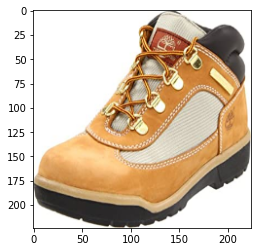

-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  4756
Categories :  Shoes
Similarity score :  0.85429347


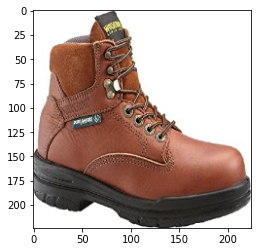


Product ID :  4905
Categories :  Shoes
Similarity score :  0.8412626


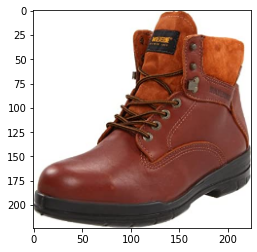


Product ID :  4920
Categories :  Shoes
Similarity score :  0.805737


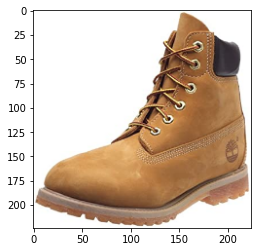


Product ID :  4863
Categories :  Shoes
Similarity score :  0.7931273


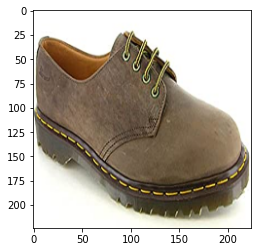


Product ID :  4813
Categories :  Shoes
Similarity score :  0.78986293


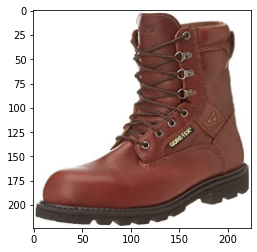

In [10]:
image_recommend(4891,5)